In [30]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
%matplotlib inline

### Import Data

In [171]:
path = 'lalonde.csv'
patients_df = pd.DataFrame.from_csv(path, sep=",")
patients_df.head(3)

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
id,,,,,,,,,,
NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.046
NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.894
NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.450


### Clean Data

In [3]:
# Cast values to numeric
patients_df.apply(pd.to_numeric, errors = 'coerce')
type(patients_df.iloc[1,1])

numpy.int64

### Split not treated and treated

In [6]:
# splits a dataframe on a two-categorical column
def split_in_two(df, column):
    first = df[df[column] == 0]
    second = df[df[column] == 1]
    return first, second

In [195]:
ntreated_df, treated_df = split_in_two(patients_df, 'treat')
ntreated_count = len(ntreated_df)
treated_count = len(treated_df)
treated_df.tail(2)

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
id,,,,,,,,,,
NSW184,1,35,8,1,0,1,1,13732.07,17976.15,3786.628
NSW185,1,33,11,1,0,1,1,14660.71,25142.24,4181.942


In [173]:
ntreated_df.head()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
id,,,,,,,,,,
PSID1,0,30,12,0,0,1,0,20166.73,18347.23,25564.67
PSID2,0,26,12,0,0,1,0,25862.32,17806.55,25564.67
PSID3,0,25,16,0,0,1,0,25862.32,15316.21,25564.67
PSID4,0,42,11,0,0,1,1,21787.05,14265.29,15491.01
PSID5,0,25,9,1,0,1,1,14829.69,13776.53,0.00


### 1. A naive analysis

Now that we have the treated and untreated person, we can compare the outcome variable

In [83]:
# obtain describe serie for both groups
dscr_ntr = ntreated_df['re78'].describe()
dscr_tr = treated_df['re78'].describe()

In [84]:
# mean of untreated group
dscr_ntr['mean']

6984.1697423076967

In [85]:
# mean of treated group
dscr_tr['mean']

6349.1435302702694

We already see that the mean of untreated group is higher, but is this an effect of outliers?

In [86]:
# 75% quantile mean of untreated group
dscr_ntr['75%']

11688.82

In [87]:
# 75% quantile mean of treated group
dscr_tr['75%']

9642.9989999999998

Hence we conclude it was not an effect of outliers and that the untreated group has an average higher wage than the treated group in 1978

We will convince ourselves by showing the number in an explicit visualization

In [8]:
def get_column_serie(df, column):
    return df[[column]].values[:, 0]

In [153]:
def make_boxplot(df1, df2, column, labels,  fill_colors):
    serie1 = get_column_serie(df1, column)
    serie2 = get_column_serie(df2, column)
    data = [serie1, serie2]
    fig, ax = plt.subplots()
    
    bp = ax.boxplot(data, patch_artist = True)
    for elem in ['boxes', 'caps']:
        plt.setp(bp[elem], color='black')
    for m in bp['medians']:
        m.set(color='red', linewidth=2)
    for idx, b in enumerate(bp['boxes']):
        b.set(facecolor = fill_colors[idx])
    
    ax.set_xticklabels(labels)

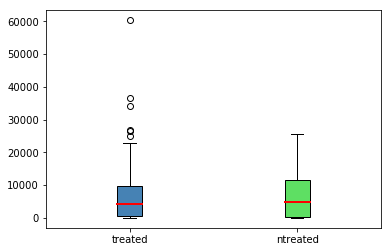

In [160]:
make_boxplot(treated_df, ntreated_df, 're78', ['treated', 'ntreated'], ['steelblue', '#5EDF63'])

Hence the plots confirms what we already knew, that the mean and mean without outliers is lower for treated patients. The naive analysis concludes the treatment does not work

### 2. A closer look at the data

#### Description
For each feature in the dataset, compare its distribution in the treated group with its distribution in the control group, using plots and numbers. As above, you may use the techniques we discussed in class for summarizing and comparing the distributions.

What do you observe? Describe what your observations mean for the conclusions drawn by the naive "researcher" from his superficial analysis.

#### Solution
In this part, we will successively compare the columns of the treated dataframe and the ntreated dataframe then try to explain what vice of procedure caused the disreptancies in the case of high difference in distribution

In [164]:
def shared_plot_by(col,plot_kind, treated_df, ntreated_df):
    fig, axs = plt.subplots(1, 2, figsize=(14,5), sharex=True)
    treated_df.plot(y=col, kind=plot_kind, ax=axs[0], title = "Treated")
    ntreated_df.plot(y=col, kind=plot_kind, ax=axs[1], title = "Not Treated")
    plt.show()

Lets first compar eboth groups <b> by age </b>

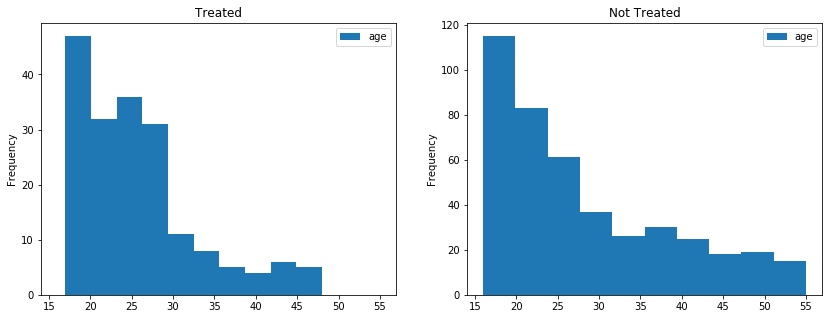

In [165]:
# First we can compare them by age
shared_plot_by('age', 'hist', treated_df, ntreated_df)

We already see that there is a big difference in proportion between 25 and 30 years. There are proportionately way more treated people in this age range than there are untreated people relative to the total number of people in each group

In [168]:
# And we can compare the values with descibe
treated_df['age'].describe()

count    185.000000
mean      25.816216
std        7.155019
min       17.000000
25%       20.000000
50%       25.000000
75%       29.000000
max       48.000000
Name: age, dtype: float64

In [169]:
ntreated_df['age'].describe()

count    429.000000
mean      28.030303
std       10.786653
min       16.000000
25%       19.000000
50%       25.000000
75%       35.000000
max       55.000000
Name: age, dtype: float64

We can see (with plots and numbers) that among the data, most of them are young people (16-25) and there are much more people not treated than treated. We can suspect that the treatment <b>assignement was not random</b> because had it be random, the number of patients in each group would have been closer to each other.

Now we can compare both groups through their respective <b>years of education</b> distribution

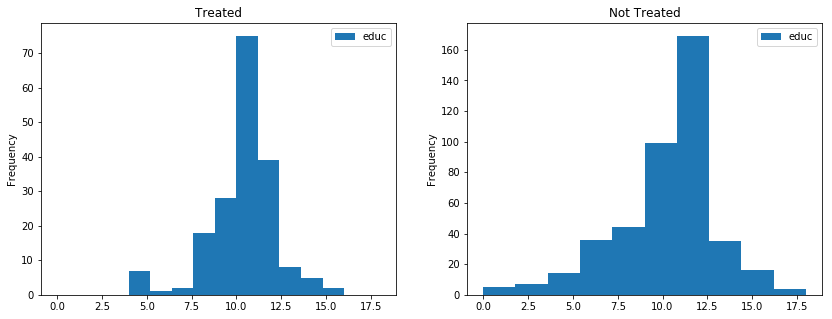

In [167]:
# Then by education
shared_plot_by('educ', 'hist', treated_df, ntreated_df)

The results here are less surprising. Since we already saw a difference in age distribution, the years of education will be influenced. Here both groups seem quite comparable

In [88]:
# and compare their values too
treated_df['educ'].describe()

count    185.000000
mean      10.345946
std        2.010650
min        4.000000
25%        9.000000
50%       11.000000
75%       12.000000
max       16.000000
Name: educ, dtype: float64

In [89]:
ntreated_df['educ'].describe()

count    429.000000
mean      10.235431
std        2.855238
min        0.000000
25%        9.000000
50%       11.000000
75%       12.000000
max       18.000000
Name: educ, dtype: float64

The results confirm our hypotheses since the mean is almost the same in both groups and the 75% quantile is exactly the same. This means that the difference in standard deviation is only due to outliers. hence both groups have very <b> similar distributions in years of education </b>

We can now compare the <b>amount of people without a degree</b> and the <b>number of people married</b> in each group

In [188]:
def col_number(df, col_names):
    result_0 = []
    result_1 = []
    
    for col_name in col_names:   
        # for each col we calculate the length and then store the ratio
        nb_0 = len(df[df[col_name] == 0])
        nb_1 = len(df[df[col_name] == 1])
        result_0.append(nb_0 / (nb_0 + nb_1))
        result_1.append(nb_1 / (nb_0 + nb_1))
        
    return np.array(result_0), np.array(result_1)

def bar_subplot(axe_plot, nb_index, result_0, result_1, ylegend):
    #plot0 = axe_plot.bar(nb_index, result_0, color="#0000ff")
    plot1 = axe_plot.bar(nb_index, result_1, color='steelblue')
    
    plt.sca(axe_plot)
    plt.xticks(nb_index, col_names)
    plt.ylabel(ylegend)
    plt.yticks( [0, 0.5, 1] )
    #plt.legend((plot0[0], plot1[0]), ('0', '1'))

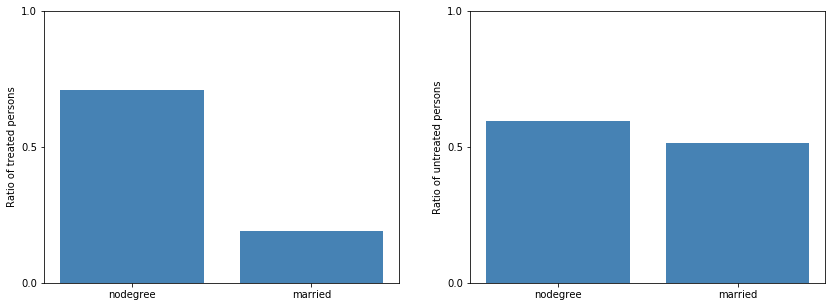

In [189]:
fig, plot_axes = plt.subplots(1, 2, figsize=(14, 5), sharex=True)
nb_index = np.arange(2)
col_names = ['nodegree', 'married']

result_0, result_1 = col_number(treated_df, col_names)
bar_subplot(plot_axes[0], nb_index, result_0, result_1, 'Ratio of treated persons')

result_0, result_1 = col_number(ntreated_df, col_names)
bar_subplot(plot_axes[1], nb_index, result_0, result_1, 'Ratio of untreated persons')

plt.show()

We see that the <b>proportion of people without a degree is quite similar</b> . However the <b>proportion of people married is very different</b>. there seem to be a ratio between 2 and 3 of the proportion of married people.
This may show a bias in the treatment assignement but <b>might be a side effect of the age difference</b> we saw before between the groups. This may have a big influence since we may expect married people to have different carreer objectives than unmarried people.

For <b>blacks and hispanic</b> we will only compare the ratios between the two groups

In [197]:
def compute_ratio(df, col, total):
    val = df[col]
    return (val == 1).sum()/total

In [198]:
compute_ratio(treated_df, 'black', treated_count)

0.84324324324324329

In [199]:
compute_ratio(ntreated_df, 'black', treated_count) 

0.4702702702702703

In [201]:
compute_ratio(treated_df, 'hispan', treated_count)

0.059459459459459463

In [202]:
compute_ratio(ntreated_df, 'hispan', ntreated_count)

0.14219114219114218

We can see that the number of blacks in the treated group is almost twice as important in proportion as in the non-treated group.   
This is a <b>non-random treatment assignement</b>

### 3. A propsensity score model

#### Description
Use logistic regression to estimate propensity scores for all points in the dataset. You may use sklearn to fit the logistic regression model and apply it to each data point to obtain propensity scores

#### Solution
We apply the logistic regression

In [174]:
logistic = linear_model.LogisticRegression()
feature_cols = ['age', 'educ', 'black', 'hispan', 'married', 'nodegree', 're74', 're75']
X = patients_df[feature_cols]
y = patients_df.treat
logistic.fit(X, y);

Then add the results in a new dataframe

In [176]:
score = logistic.predict_proba(X)
patients_score_df = patients_df.copy()
patients_score_df["score"] = score[:,1]
patients_score_df.head(3)

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,score
id,,,,,,,,,,,
NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.046,0.443350
NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.894,0.144660
NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.450,0.722355


The score column give the probability of being treated given the pre-treatment features (all but re78)

### 4. Balancing the dataset via matching

#### Description
Use the propensity scores to match each data point from the treated group with exactly one data point from the control group, while ensuring that each data point from the control group is matched with at most one data point from the treated group. (Hint: you may explore the networkx package in Python for predefined matching functions.)

#### Solution

First we need to separate the patient treated from the untreated and then see if it match with the propsensity score

In [98]:
patients_treated = patients_score_df.loc[patients_score_df['treat'] == 1]
patients_not_treated = patients_score_df.loc[patients_score_df['treat'] == 0]
patients_treated.head()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,score_0,score_1
id,,,,,,,,,,,,
NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460,0.541926,0.458074
NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940,0.848020,0.151980
NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500,0.249034,0.750966
NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460,0.325980,0.674020
NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899,0.329410,0.670590


In [99]:
patients_not_treated.head()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,score_0,score_1
id,,,,,,,,,,,,
PSID1,0,30,12,0,0,1,0,20166.73,18347.23,25564.67,0.934356,0.065644
PSID2,0,26,12,0,0,1,0,25862.32,17806.55,25564.67,0.953584,0.046416
PSID3,0,25,16,0,0,1,0,25862.32,15316.21,25564.67,0.969547,0.030453
PSID4,0,42,11,0,0,1,1,21787.05,14265.29,15491.01,0.967729,0.032271
PSID5,0,25,9,1,0,1,1,14829.69,13776.53,0.00,0.625627,0.374373


In [100]:
len(patients_treated.index)

185

In [101]:
len(patients_not_treated.index)

429

We can see that there are less the patient treated than not treated. That's why we need to find only 1 match with the untreated patients <br>
To do this, we need to see the distance between each data point from the treated group with exactly one data point from the control group (the not treated ones).

In [34]:
#To calculate the distance (here we have 1 axis)
def compute_dist(x1, x2):
    return np.sqrt(np.power(x1 - x2, 2))

In [35]:
def matching_only_one(treated, ntreated, match_score):
    matching = []
    idx_npatient_used = []
    
    for patient_idx in treated.index:
        patient = treated.loc[patient_idx]
        patient_score = patient[match_score]
        
        min_dist = 10000000 # an arbitrary big number (the distance will be always below)
        match = []
        
        for npatient_idx in ntreated.index:
            npatient = ntreated.loc[npatient_idx]
            npatient_score = npatient[match_score]
            
            dist = compute_dist(patient_score, npatient_score)
            
            if(dist < min_dist):
                # we need to look if the untreated patient index was already used
                if(npatient_idx not in idx_npatient_used):
                    match = [patient_idx, npatient_idx]
                    min_dist = dist
                    
        matching.append(match)
        idx_npatient_used.append(match[1])
        
    return matching   

In [36]:
matching = matching_only_one(patients_treated, patients_not_treated, "score_1")

Verification that we have only one match and that they are all different

In [102]:
def verify_one_match(list_):
    for i in range(len(list_)):
        psid1 = list_[i][1]
        for j in range(len(list_)):
            psid2 = list_[j][1]
            if(i != j and psid1 == psid2):
                return False
    
    return True
                

In [38]:
verify_one_match(matching)

True

Now that we have the match we can compare the values of the treated and not treated persons

In [39]:
patients_treated['re78'].describe()

count      185.000000
mean      6349.143530
std       7867.402218
min          0.000000
25%        485.229800
50%       4232.309000
75%       9642.999000
max      60307.930000
Name: re78, dtype: float64

In [40]:
patients_not_treated_matched = patients_not_treated.loc[np.array(matching)[:,1]]
patients_not_treated_matched['re78'].describe()

count      185.000000
mean      5828.584903
std       6094.306306
min          0.000000
25%        237.914000
50%       4112.513000
75%       8957.978000
max      25564.670000
Name: re78, dtype: float64

We can see that they look alike and our conclusion will be better than what we have done before. We can plot them to see the differences.

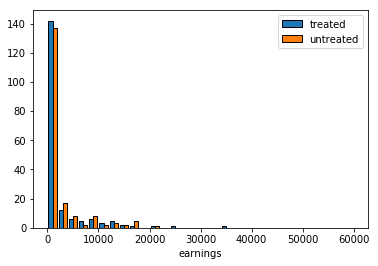

In [103]:
make_comparative_histogram(patients_treated, patients_not_treated_matched, 're74', bins_, 'earnings', ['treated', 'untreated'])

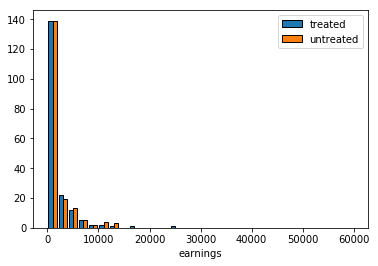

In [104]:
make_comparative_histogram(patients_treated, patients_not_treated_matched, 're75', bins_, 'earnings', ['treated', 'untreated'])

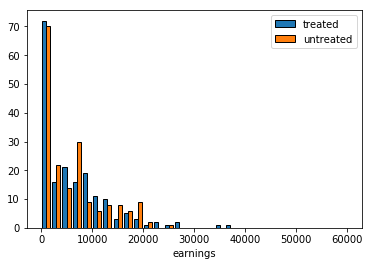

In [105]:
make_comparative_histogram(patients_treated, patients_not_treated_matched, 're78', bins_, 'earnings', ['treated', 'untreated'])

We can see that the plots are very similar and give us better informations about the treated and untreated people.
Here with the analysis, we can conclude that the treatment doesn't really work because the real earnings are not higher for the treated persons than the untreated ones. So it seems logical to say that applying for this job training program has no influences. Furthermore, the differences could be caused by economic fluctuations or that maybe a the salary involves having more experiences and better skills than the training job can bring.

We can now compare the age, education and the other parameters that we have to see how the repartition of the data is done 

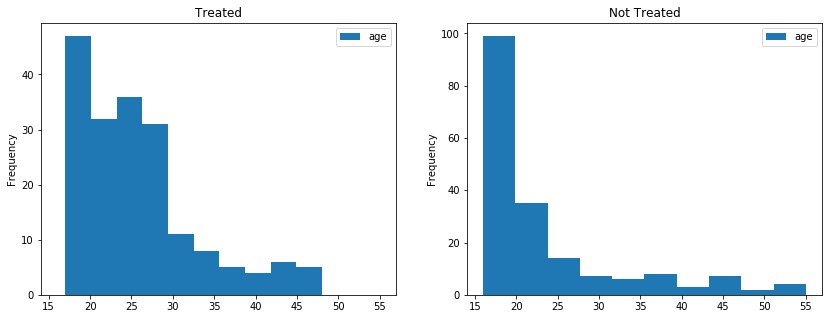

In [95]:
shared_plot_by('age', 'hist', patients_treated, patients_not_treated_matched)

In [45]:
patients_treated['age'].describe()

count    185.000000
mean      25.816216
std        7.155019
min       17.000000
25%       20.000000
50%       25.000000
75%       29.000000
max       48.000000
Name: age, dtype: float64

In [46]:
patients_not_treated_matched['age'].describe()

count    185.000000
mean      23.167568
std        9.337805
min       16.000000
25%       17.000000
50%       19.000000
75%       24.000000
max       55.000000
Name: age, dtype: float64

We can see that there are much more very young people that didn't get this job training program. However both distribution has mean around 24 years old. Furthermore, we can see that for the untreated ones, the interval between the youngest and the oldest is bigger (16-55) than the treated one (17-48). So the distribution of the untreated person is more expended and can explain this mean around 24 years old.

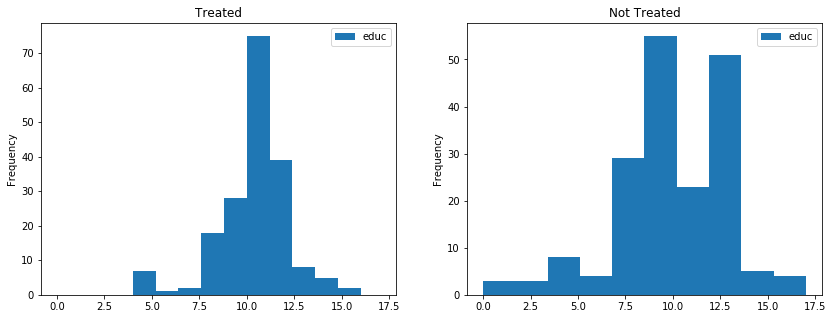

In [106]:
shared_plot_by('educ', 'hist', patients_treated, patients_not_treated_matched)

In [107]:
patients_treated['educ'].describe()

count    185.000000
mean      10.345946
std        2.010650
min        4.000000
25%        9.000000
50%       11.000000
75%       12.000000
max       16.000000
Name: educ, dtype: float64

In [108]:
patients_not_treated_matched['educ'].describe()

count    185.000000
mean       9.864865
std        2.775692
min        0.000000
25%        8.000000
50%       10.000000
75%       12.000000
max       17.000000
Name: educ, dtype: float64

The distributions of education can be compared to a gaussian distribution with both mean around 10. Furthermore, if we look at the graph, most of the people how studied for a long time (around 10 years) took this job training program. Maybe the reason is that after about 10 years of study, another training can bring or supplement useful skills for a job.

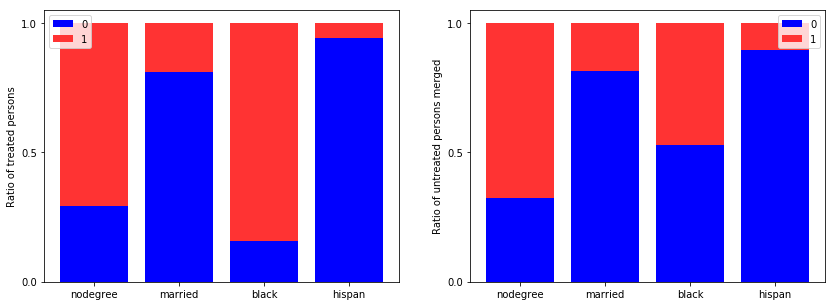

In [50]:
fig, plot_axes = plt.subplots(1, 2, figsize=(14, 5), sharex=True)
nb_index = np.arange(4)
col_names = ['nodegree', 'married', 'black', 'hispan']

result_0, result_1 = col_number(patients_treated, col_names)
bar_subplot(plot_axes[0], nb_index, result_0, result_1, 'Ratio of treated persons')

result_0, result_1 = col_number(patients_not_treated_matched, col_names)
bar_subplot(plot_axes[1], nb_index, result_0, result_1, 'Ratio of untreated persons merged')

plt.show()

We can see that the proportion of person with or without a degree is very similar in both groups. However it is still a little bit higher (red) in the treatment group, which one can conclude that if someone has no diploma, he will take the training. <br>
For the married people and hispanic ones, the proportions are the sames and it's important because with the same proportion, the final results will be coherent.<br>

### 5. Balancing the groups further

### Task 2.1

#### Description
Load the 20newsgroup dataset. It is, again, a classic dataset that can directly be loaded using sklearn ([link](http://scikit-learn.org/stable/datasets/twenty_newsgroups.html)).  
[TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf), short for term frequency–inverse document frequency, is of great help when if comes to compute textual features. Indeed, it gives more importance to terms that are more specific to the considered articles (TF) but reduces the importance of terms that are very frequent in the entire corpus (IDF). Compute TF-IDF features for every article using [TfidfVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html). Then, split your dataset into a training, a testing and a validation set (10% for validation and 10% for testing). Each observation should be paired with its corresponding label (the article category).

#### Solution
We start by loading the dataset

In [240]:
from sklearn.datasets import fetch_20newsgroups
# Retrieve data
news_data = fetch_20newsgroups(remove=('headers', 'footers', 'quotes'))['data']

In [241]:
# See what an element looks like
news_data[0]

'I was wondering if anyone out there could enlighten me on this car I saw\nthe other day. It was a 2-door sports car, looked to be from the late 60s/\nearly 70s. It was called a Bricklin. The doors were really small. In addition,\nthe front bumper was separate from the rest of the body. This is \nall I know. If anyone can tellme a model name, engine specs, years\nof production, where this car is made, history, or whatever info you\nhave on this funky looking car, please e-mail.'

In [242]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5,
                                 stop_words='english')
X = vectorizer.fit(news_data)